In [13]:
import pandas as pd

# Load dataset
df = pd.read_pickle("merged_training.pkl")

# Basic info
print(df.shape)
print(df.columns)
df.head()


(416809, 2)
Index(['text', 'emotions'], dtype='object')


,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


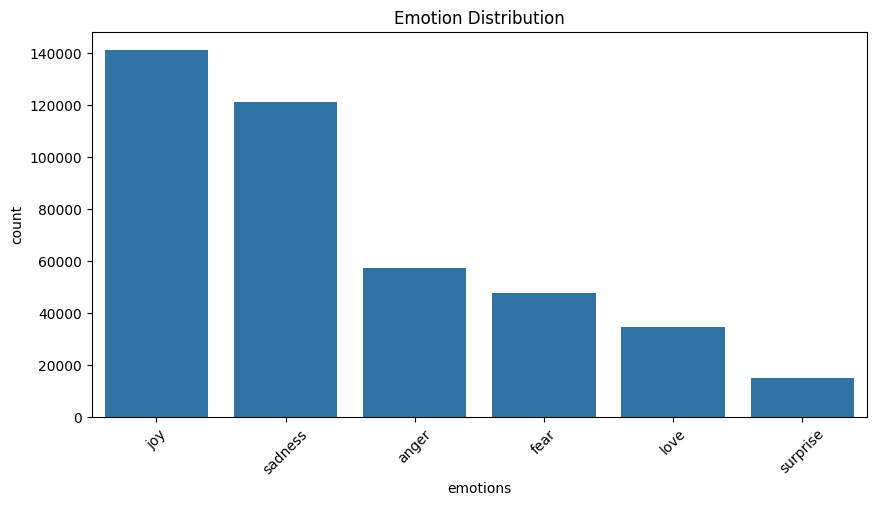

text        0
emotions    0
dtype: int64


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check class balance
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='emotions', order=df['emotions'].value_counts().index)
plt.title("Emotion Distribution")
plt.xticks(rotation=45)
plt.show()

# Check for nulls
print(df.isnull().sum())

# Drop nulls if any
df.dropna(inplace=True)


In [16]:
import neattext.functions as nfx

# Clean text: remove mentions, URLs, hashtags, punctuation, etc.
df['clean_text'] = df['text'].apply(nfx.remove_userhandles)
df['clean_text'] = df['clean_text'].apply(nfx.remove_urls)
df['clean_text'] = df['clean_text'].apply(nfx.remove_special_characters)
df['clean_text'] = df['clean_text'].apply(nfx.remove_punctuations)
df['clean_text'] = df['clean_text'].apply(nfx.remove_multiple_spaces)
df['clean_text'] = df['clean_text'].apply(lambda x: x.lower().strip())


In [17]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['emotions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Pipeline
model_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train
model_pipeline.fit(X_train, y_train)

# Predict
y_pred = model_pipeline.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       anger       0.89      0.91      0.90     11463
        fear       0.85      0.84      0.85      9542
         joy       0.91      0.93      0.92     28214
        love       0.81      0.76      0.78      6911
     sadness       0.94      0.94      0.94     24238
    surprise       0.77      0.71      0.74      2994

    accuracy                           0.90     83362
   macro avg       0.86      0.85      0.85     83362
weighted avg       0.90      0.90      0.90     83362



In [19]:
import joblib

# Save model
joblib.dump(model_pipeline, "emotion_model.pkl")


['emotion_model.pkl']

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['text'])
y = df['emotions']


In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [24]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)


c:\Users\heyin\OneDrive\Desktop\EMO(TEXT)\emotion_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:50:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
from sklearn.metrics import classification_report

y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       anger       0.92      0.88      0.90     11339
        fear       0.87      0.84      0.85      9376
         joy       0.93      0.90      0.91     28247
        love       0.74      0.90      0.82      6853
     sadness       0.96      0.93      0.94     24504
    surprise       0.70      0.88      0.78      3043

    accuracy                           0.90     83362
   macro avg       0.85      0.89      0.87     83362
weighted avg       0.90      0.90      0.90     83362



In [26]:
import joblib

joblib.dump(xgb, "xgb_emotion_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']